Columns

Each row in the file corresponds to a single player's involvement in a single play. The dataset was intentionally joined (i.e. denormalized) to make the API simple. All the columns are contained in one large dataframe which is grouped and provided by PlayId.

- GameId - a unique game identifier
- PlayId - a unique play identifier
- Team - home or away
- X - player position along the long axis of the field. See figure below.
- Y - player position along the short axis of the field. See figure below.
- S - speed in yards/second
- A - acceleration in yards/second^2
- Dis - distance traveled from prior time point, in yards
    -  Dis measures time covered in the most recent window of player tracking data. Given that tracking data roughly covers 10 frames per second, Dis corresponds to distance traveled in the recent 0.1 seconds. Note that speed and acceleration are directly calculated using Dis (this is done in the data pre-processing)
- Orientation - orientation of player (deg)
- Dir - angle of player motion (deg)
- NflId - a unique identifier of the player
- DisplayName - player's name
- JerseyNumber - jersey number
- Season - year of the season
- YardLine - the yard line of the line of scrimmage
- Quarter - game quarter (1-5, 5 == overtime)
- GameClock - time on the game clock
- PossessionTeam - team with possession
- Down - the down (1-4)
- Distance - yards needed for a first down
- FieldPosition - which side of the field the play is happening on
- HomeScoreBeforePlay - home team score before play started
- VisitorScoreBeforePlay - visitor team score before play started
- NflIdRusher - the NflId of the rushing player
- OffenseFormation - offense formation
- OffensePersonnel - offensive team positional grouping
- DefendersInTheBox - number of defenders lined up near the line of scrimmage, spanning the width of the offensive line
- DefensePersonnel - defensive team positional grouping
- PlayDirection - direction the play is headed
- TimeHandoff - UTC time of the handoff
- TimeSnap - UTC time of the snap
- Yards - the yardage gained on the play (you are predicting this)
- PlayerHeight - player height (ft-in)
- PlayerWeight - player weight (lbs)
- PlayerBirthDate - birth date (mm/dd/yyyy)
- PlayerCollegeName - where the player attended college
- Position - the player's position (the specific role on the field that they typically play)
- HomeTeamAbbr - home team abbreviation
- VisitorTeamAbbr - visitor team abbreviation
- Week - week into the season
- Stadium - stadium where the game is being played
- Location - city where the game is being player
- StadiumType - description of the stadium environment
- Turf - description of the field surface
- GameWeather - description of the game weather
- Temperature - temperature (deg F)
- Humidity - humidity
- WindSpeed - wind speed in miles/hour
- WindDirection - wind direction

https://www.kaggle.com/c/nfl-big-data-bowl-2020/data

In [465]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.patches as patches
from draw_football_field import create_football_field
import seaborn as sns
import datetime, tqdm
from string import punctuation
import re


import math

pd.set_option('display.max_columns', 500)

In [466]:
def emptyLine(numlines=1):
    print('*'*60*numlines)

In [467]:
# Load data
train = pd.read_csv('train.csv')

# From https://www.kaggle.com/cpmpml/initial-wrangling-voronoi-areas-in-python
train.loc[train.VisitorTeamAbbr == "ARI", 'VisitorTeamAbbr'] = "ARZ"
train.loc[train.HomeTeamAbbr == "ARI", 'HomeTeamAbbr'] = "ARZ"

train.loc[train.VisitorTeamAbbr == "BAL", 'VisitorTeamAbbr'] = "BLT"
train.loc[train.HomeTeamAbbr == "BAL", 'HomeTeamAbbr'] = "BLT"

train.loc[train.VisitorTeamAbbr == "CLE", 'VisitorTeamAbbr'] = "CLV"
train.loc[train.HomeTeamAbbr == "CLE", 'HomeTeamAbbr'] = "CLV"

train.loc[train.VisitorTeamAbbr == "HOU", 'VisitorTeamAbbr'] = "HST"
train.loc[train.HomeTeamAbbr == "HOU", 'HomeTeamAbbr'] = "HST"



## Data Exploration

count    509762.000000
mean          4.212334
std           6.436167
min         -14.000000
0.3%         -6.000000
5%           -2.000000
25%           1.000000
50%           3.000000
75%           6.000000
95%          14.000000
99.7%        50.000000
max          99.000000
Name: Yards, dtype: float64


/Users/dalpengholic/anaconda3/envs/nbastat1/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/dalpengholic/anaconda3/envs/nbastat1/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


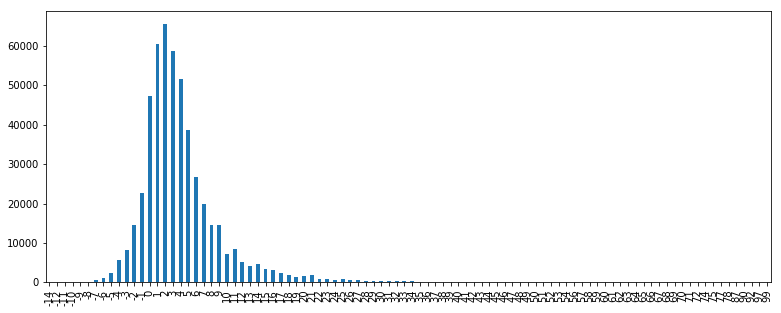

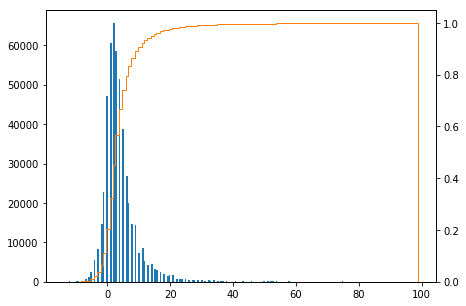

In [468]:
# Result of handsoff
print(train.Yards.describe(percentiles=[0.003, 0.05, 0.25, 0.95, 0.75, 0.997]))
train.Yards.value_counts().sort_index().plot(kind='bar',figsize=(13,5),rot=90)

series =train.Yards
fig, ax = plt.subplots(figsize=(7,5))
ax2 = ax.twinx()
n, bins, patches = ax.hist(series, bins=199, normed=False)
n, bins, patches = ax2.hist(series, cumulative=1, histtype='step', bins=199, color='tab:orange',  normed=True)

In [469]:
# Check empty cells in each column
print("Shape of dataframe: ",train.shape); emptyLine()
print("Num of unique GameId: ",len(train.GameId.unique().tolist())); emptyLine()
print(train.columns[train.isna().any()].tolist()); emptyLine()
print("Max of TimeHandoff", train.TimeHandoff.max())
print("Min of TimeHandoff", train.TimeHandoff.min())
train.isna().sum()

Shape of dataframe:  (509762, 49)
************************************************************
Num of unique GameId:  512
************************************************************
['Orientation', 'Dir', 'FieldPosition', 'OffenseFormation', 'DefendersInTheBox', 'StadiumType', 'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection']
************************************************************
Max of TimeHandoff 2018-12-31T04:18:19.000Z
Min of TimeHandoff 2017-09-08T00:44:06.000Z


GameId                        0
PlayId                        0
Team                          0
X                             0
Y                             0
S                             0
A                             0
Dis                           0
Orientation                  18
Dir                          14
NflId                         0
DisplayName                   0
JerseyNumber                  0
Season                        0
YardLine                      0
Quarter                       0
GameClock                     0
PossessionTeam                0
Down                          0
Distance                      0
FieldPosition              6424
HomeScoreBeforePlay           0
VisitorScoreBeforePlay        0
NflIdRusher                   0
OffenseFormation            110
OffensePersonnel              0
DefendersInTheBox            66
DefensePersonnel              0
PlayDirection                 0
TimeHandoff                   0
TimeSnap                      0
Yards   

In [470]:
cat_features = []
for col in train.columns:
    if train[col].dtype =='object':
        cat_features.append((col, len(train[col].unique())))
        
cat_features

[('Team', 2),
 ('DisplayName', 2230),
 ('GameClock', 901),
 ('PossessionTeam', 32),
 ('FieldPosition', 33),
 ('OffenseFormation', 9),
 ('OffensePersonnel', 56),
 ('DefensePersonnel', 38),
 ('PlayDirection', 2),
 ('TimeHandoff', 22935),
 ('TimeSnap', 22943),
 ('PlayerHeight', 16),
 ('PlayerBirthDate', 1688),
 ('PlayerCollegeName', 301),
 ('Position', 25),
 ('HomeTeamAbbr', 32),
 ('VisitorTeamAbbr', 32),
 ('Stadium', 55),
 ('Location', 60),
 ('StadiumType', 30),
 ('Turf', 20),
 ('GameWeather', 62),
 ('WindSpeed', 59),
 ('WindDirection', 54)]

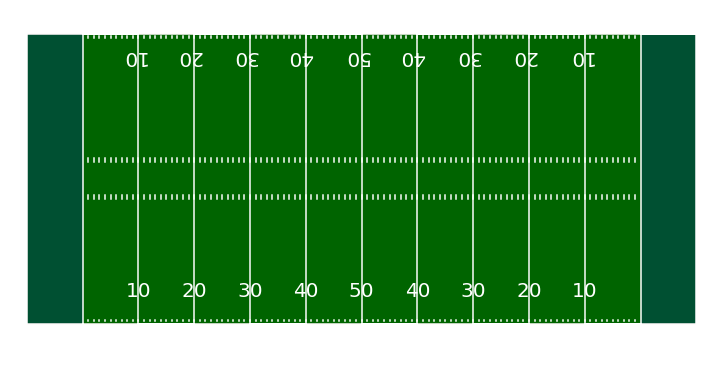

In [471]:
# Draw football field
# From https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position
create_football_field()
plt.show()

No handles with labels found to put in legend.


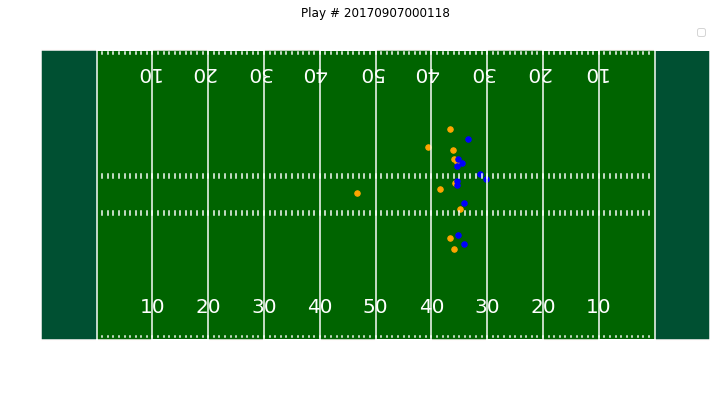

In [472]:
fig, ax = create_football_field()
train.query("PlayId == 20170907000118 and Team == 'away'") \
    .plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=30, legend='Away')
train.query("PlayId == 20170907000118 and Team == 'home'") \
    .plot(x='X', y='Y', kind='scatter', ax=ax, color='blue', s=30, legend='Home')
plt.title('Play # 20170907000118')
plt.legend()
plt.show()

In [473]:
# playid = 20181230154157
# train.query("PlayId == @playid").head()
# yl = train.query("PlayId == @playid")['YardLine'].tolist()[0]
# fig, ax = create_football_field(highlight_line=True,
#                                 highlight_line_number=yl+54)
# train.query("PlayId == @playid and Team == 'away'") \
#     .plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=30, legend='Away')
# train.query("PlayId == @playid and Team == 'home'") \
#     .plot(x='X', y='Y', kind='scatter', ax=ax, color='blue', s=30, legend='Home')
# plt.title(f'Play # {playid}')
# plt.legend()
# plt.show()

In [474]:
train.head(22)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
5,2017090700,20170907000118,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,2543494,Dee Ford,55,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-2,252,03/19/1991,Auburn,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
6,2017090700,20170907000118,away,74.11,16.64,1.11,0.83,0.02,357.23,322.59,2543637,Terrance Mitchell,39,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,5-11,190,05/17/1992,Oregon,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
7,2017090700,20170907000118,away,73.37,18.73,1.24,0.74,0.13,328.52,270.04,2543851,Phillip Gaines,23,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,193,04/04/1991,Rice,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
8,2017090700,20170907000118,away,56.63,26.90,0.26,1.86,0.28,344.70,55.31,2550257,Daniel Sorensen,49,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-2,208,03/05/1990,Brigham Young,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
9,2017090700,20170907000118,away,73.35,38.83,4.55,0.76,0.51,75.47,190.84,2552488,Marcus Peters,22,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB

## Feature Cleaning
### Stadium

In [475]:
%%time
# Stadium clean
# from https://www.kaggle.com/truenikita/neural-networks-multiple-output-stadium-clean
# 33 stadiums =  32 teams - 1 jets/giants share - 1rams/chargers share + wembley + twickenham + azteca.
# 34 stadiums = rams chargers don't share according to wiki

map_stad = {'Broncos Stadium at Mile High': 'Broncos Stadium At Mile High', \
            'CenturyField': 'CenturyLink Field', 'CenturyLink': 'CenturyLink Field', 'Everbank Field': 'TIAA Bank Field',\
            'FirstEnergy': 'First Energy Stadium', 'FirstEnergy Stadium': 'First Energy Stadium', \
            'FirstEnergyStadium': 'First Energy Stadium', 'Lambeau field': 'Lambeau Field', \
            'Los Angeles Memorial Coliesum': 'Los Angeles Memorial Coliseum', 'M & T Bank Stadium': 'M&T Bank Stadium',\
            'M&T Stadium': 'M&T Bank Stadium', 'Mercedes-Benz Dome': 'Mercedes-Benz Superdome',\
            'MetLife': 'MetLife Stadium', 'Metlife Stadium': 'MetLife Stadium', 'NRG': 'NRG Stadium',\
            'Oakland Alameda-County Coliseum': 'Oakland-Alameda County Coliseum', 'Paul Brown Stdium': 'Paul Brown Stadium',\
            'Twickenham': 'Twickenham Stadium', 'EverBank Field': 'TIAA Bank Field', \
            'Sports Authority Field at Mile High': 'Broncos Stadium At Mile High' ,'University of Phoenix Stadium':'State Farm Stadium'}

for stad in train['Stadium'].unique():
    if stad in map_stad.keys():
        pass
    else:
        map_stad[stad]=stad

train['Stadium'] = train['Stadium'].map(map_stad)
print("Number of Stadium: ", len(train.Stadium.unique()))
len(train.Stadium.unique())

Number of Stadium:  34
CPU times: user 121 ms, sys: 8.4 ms, total: 129 ms
Wall time: 162 ms


In [476]:
# Drop 'Location', which is redundant
train = train.drop('Location', axis=1)

### Turf (Grass_label : natural or not)

In [477]:
%%time
# Feature transformation: Turf 
# from https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/112681#latest-655119
grass_labels = ['grass', 'natural grass', 'natural', 'naturall grass']
train['NaturalGrass'] = np.where(train.Turf.str.lower().isin(grass_labels), 1, 0)


CPU times: user 163 ms, sys: 30.6 ms, total: 194 ms
Wall time: 201 ms


In [478]:
# Drop 'Turf' column
train = train.drop('Turf', axis=1)
# Drop ''PlayerCollegeName" column
train = train.drop('PlayerCollegeName', axis=1)

## Feature extraction
### Age

In [479]:
%%time
def func_convert_to_datetime():
    train['PlayerBirthDate'] = pd.to_datetime(train['PlayerBirthDate'], infer_datetime_format=True)
    train['TimeSnap'] = pd.to_datetime(train['TimeSnap'], infer_datetime_format=True).dt.tz_convert(None)
    train['TimeHandoff'] = pd.to_datetime(train['TimeHandoff'], infer_datetime_format=True).dt.tz_convert(None)

func_convert_to_datetime()

CPU times: user 2.09 s, sys: 60.4 ms, total: 2.15 s
Wall time: 2.26 s


In [480]:
%%time
def func_get_player_age():
    '''
    Get player's age at the time the player played
    '''
    train['PlayerAge'] = train['TimeSnap'] - train['PlayerBirthDate']
    train['PlayerAge'] = train['PlayerAge'].apply(lambda x: (float(x.days)/365)).round(1)

func_get_player_age()    
train.head(2)

CPU times: user 5.44 s, sys: 620 ms, total: 6.06 s
Wall time: 6.5 s


In [481]:
# Drop 'PlayerBirthDate'
train = train.drop('PlayerBirthDate', axis=1)

## Feature extraction
### TimeBetween_SnapHandoff = TimeHandoff - TimeSnap

In [482]:
%%time
def func_get_time_SnapHandoff():
    '''
    Get time difference between snap and handoff
    '''
    train['TimeBetween_SnapHandoff'] = train['TimeHandoff'] - train['TimeSnap'] 
    train['TimeBetween_SnapHandoff'] = train['TimeBetween_SnapHandoff'].apply(lambda x: x.total_seconds())

func_get_time_SnapHandoff()

CPU times: user 5.52 s, sys: 179 ms, total: 5.7 s
Wall time: 6 s


## Feature Cleaning
### StadiumType

In [483]:
print(train['StadiumType'].unique()); emptyLine()
print(len(train['StadiumType'].unique()))

['Outdoor' 'Outdoors' 'Indoors' 'Retractable Roof' 'Indoor'
 'Retr. Roof-Closed' 'Open' nan 'Indoor, Open Roof' 'Retr. Roof - Closed'
 'Outddors' 'Dome' 'Domed, closed' 'Indoor, Roof Closed'
 'Retr. Roof Closed' 'Outdoor Retr Roof-Open' 'Closed Dome' 'Oudoor'
 'Ourdoor' 'Dome, closed' 'Retr. Roof-Open' 'Heinz Field' 'Outdor'
 'Retr. Roof - Open' 'Domed, Open' 'Domed, open' 'Cloudy' 'Bowl' 'Outside'
 'Domed']
************************************************************
30


In [484]:
# From https://www.kaggle.com/bgmello/neural-networks-feature-engineering-for-the-win
def clean_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    txt = txt.replace('outside', 'outdoor')
    txt = txt.replace('outdor', 'outdoor')
    txt = txt.replace('outddors', 'outdoor')
    txt = txt.replace('outdoors', 'outdoor')
    txt = txt.replace('oudoor', 'outdoor')
    txt = txt.replace('indoors', 'indoor')
    txt = txt.replace('ourdoor', 'outdoor')
    txt = txt.replace('retractable', 'rtr.')
    return txt

train['StadiumType'] = train['StadiumType'].apply(clean_StadiumType)

In [485]:
def transform_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    if 'outdoor' in txt or 'open' in txt:
        return 1
    if 'indoor' in txt or 'closed' in txt:
        return 0
    
    return np.nan

In [486]:
train['StadiumType'] = train['StadiumType'].apply(transform_StadiumType)
train['StadiumType'].value_counts(dropna=False)

 1.0    356532
 0.0     82610
NaN      70620
Name: StadiumType, dtype: int64

## Feature Cleaning
### GameClock

In [487]:
%%time
def func_convert_game_clock():
    train['GameClock'] = train['GameClock'].apply(lambda x: int(x.split(':')[0])*60+ int(x.split(':')[1]))

func_convert_game_clock()

CPU times: user 764 ms, sys: 67.8 ms, total: 832 ms
Wall time: 881 ms


## Feature Cleaning
### PlayerHeight and PlayerBMI

In [488]:
# From https://www.kaggle.com/bgmello/neural-networks-feature-engineering-for-the-win
%%time
train['PlayerHeight'] = train['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
train['PlayerBMI'] = 703*(train['PlayerWeight']/(train['PlayerHeight'])**2)

UsageError: Line magic function `%%time` not found.


In [489]:
train.head(2)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,StadiumType,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,NaturalGrass,PlayerAge,TimeBetween_SnapHandoff
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,854,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-0,212,SS,NE,KC,1,Gillette Stadium,1.0,Clear and warm,63.0,77.0,8,SW,0,28.7,1.0
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,854,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-3,288,DE,NE,KC,1,Gillette Stadium,1.0,Clear and warm,63.0,77.0,8,SW,0,28.5,1.0


### Thought_1
- DisplayName is duplicated info to NflId
- [Done] JerseyNumber, PlayerCollegeName are irrelevant to machine
- [Done] Location can be dupliated info to Stadium
- [Done] Feature transformation: Age using PlayerBirthDate 
- [Done] Feature transformation : TimeDifference_SnapHandoff = TimeHandoff - TimeSnap
- StadiumType should be onehotencoded

### Thought_2
- From Big Data Bowl - Comprehensive EDA with Pandas (https://www.kaggle.com/robikscube/big-data-bowl-comprehensive-eda-with-pandas)
    - Defender in the box vs Yards
    - DL-LB combo vs Yards

In [407]:
train.head(2)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,StadiumType,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,NaturalGrass,PlayerAge,TimeBetween_SnapHandoff
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-0,212,SS,NE,KC,1,Gillette Stadium,1.0,Clear and warm,63.0,77.0,8,SW,0,28.7,1.0
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-3,288,DE,NE,KC,1,Gillette Stadium,1.0,Clear and warm,63.0,77.0,8,SW,0,28.5,1.0


In [386]:
mini_train1 = train.head(22)

### Small data set

In [513]:
mini_train1.head(22)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,StadiumType,GameWeather,Temperature,NaturalGrass,PlayerAge,TimeBetween_SnapHandoff
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-0,212,SS,NE,KC,1,Gillette Stadium,Outdoor,Clear and warm,63.0,0,28.7,1.0
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-3,288,DE,NE,KC,1,Gillette Stadium,Outdoor,Clear and warm,63.0,0,28.5,1.0
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-3,270,DE,NE,KC,1,Gillette Stadium,Outdoor,Clear and warm,63.0,0,28.6,1.0
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-3,245,ILB,NE,KC,1,Gillette Stadium,Outdoor,Clear and warm,63.0,0,34.8,1.0
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-0,206,FS,NE,KC,1,Gillette Stadium,Outdoor,Clear and warm,63.0,0,30.1,1.0
5,2017090700,20170907000118,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,2543494,Dee Ford,55,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-2,252,DE,NE,KC,1,Gillette Stadium,Outdoor,Clear and warm,63.0,0,26.5,1.0
6,2017090700,20170907000118,away,74.11,16.64,1.11,0.83,0.02,357.23,322.59,2543637,Terrance Mitchell,39,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,5-11,190,CB,NE,KC,1,Gillette Stadium,Outdoor,Clear and warm,63.0,0,25.3,1.0
7,2017090700,20170907000118,away,73.37,18.73,1.24,0.74,0.13,328.52,270.04,2543851,Phillip Gaines,23,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-0,193,CB,NE,KC,1,Gillette Stadium,Outdoor,Clear and warm,63.0,0,26.4,1.0
8,2017090700,20170907000118,away,56.63,26.90,0.26,1.86,0.28,344.70,55.31,2550257,Daniel Sorensen,49,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-2,208,SS,NE,KC,1,Gillette Stadium,Outdoor,Clear and warm,63.0,0,27.5,1.0
9,2017090700,20170907000118,away,73.35,38.83,4.55,0.76,0.51,75.47,190.84,2552488,Marcus Peters,22,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-0,197,CB,NE,KC,1,Gillette Stadium,Outdoor,Clear and warm,63.0,0,24.7,1.0


In [388]:
mini_train1.shape

(22, 48)

In [389]:
# Remove ['Humidity', 'WindSpeed','WindDirection'] features for make it straightforward
mini_drop_list = ['Humidity', 'WindSpeed','WindDirection']
mini_train1 = mini_train1.drop(mini_drop_list, axis=1)

In [509]:
oneUniqueList=[]
nonUniqueList=[]

for column in mini_train1.columns:
    if len(mini_train1[column].unique()) == 1:
        oneUniqueList.append(column)
    else:
         nonUniqueList.append((column, len(mini_train1[column].unique())))    

In [511]:
for i in nonUniqueList:
    print(i)

('Team', 2)
('X', 21)
('Y', 22)
('S', 21)
('A', 22)
('Dis', 18)
('Orientation', 22)
('Dir', 22)
('NflId', 22)
('DisplayName', 22)
('JerseyNumber', 22)
('PlayerHeight', 10)
('PlayerWeight', 21)
('Position', 13)
('PlayerAge', 20)


In [518]:
mini_train1.head(2)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,StadiumType,GameWeather,Temperature,NaturalGrass,PlayerAge,TimeBetween_SnapHandoff
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-0,212,SS,NE,KC,1,Gillette Stadium,Outdoor,Clear and warm,63.0,0,28.7,1.0
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,6-3,288,DE,NE,KC,1,Gillette Stadium,Outdoor,Clear and warm,63.0,0,28.5,1.0


In [519]:
train.FieldPosition.unique()

array(['NE', 'KC', nan, 'BUF', 'NYJ', 'ATL', 'CHI', 'CIN', 'BLT', 'CLV',
       'PIT', 'ARZ', 'DET', 'JAX', 'HST', 'TEN', 'OAK', 'WAS', 'PHI',
       'LA', 'IND', 'GB', 'SEA', 'CAR', 'SF', 'DAL', 'NYG', 'NO', 'MIN',
       'DEN', 'LAC', 'TB', 'MIA'], dtype=object)